## Project Introduction

link to project GitHub Repository: https://github.com/MDakshithagithub/Language_Translation_LLM/blob/main/llm.ipynb

In this project, we seek to use LLMs to translate phrases from foreign languages to English and compare them with the translation found within the dataset to ascertain the accuracy of LLM translations. We begin by loading datasets containing sentences in foreign languages along with their english counterparts. We then perform exploratory data analysis on these datasets to examine their contents.

LLMs are then used to translate the foreign language sentences, and the quality of these translations are then assessed by calculating the BLEU Score with the english translation from the dataset used as reference.

In doing this, we hope to identify the strengths and weaknesses of LLM translations and we seek to identify how to make LLM translations more accurate.

## Data Preparation

In [ ]:
import requests
import pandas as pd
import time
import seaborn as sns

from datasets import load_dataset

import sacrebleu
from rouge import Rouge
import bert_score

import matplotlib.pyplot as plt

from transformers import MarianMTModel, MarianTokenizer

In [ ]:
dataset = load_dataset("mt_eng_vietnamese", 'iwslt2015-en-vi')

### Retreiving Vietnamese-English Dataset

In [ ]:
train_data = dataset["train"]
validation_data = dataset['validation']
test_data = dataset['test']

# Extract English and Vietnamese translations
english_translations = [sample['translation']['en'] for sample in train_data]
vietnamese_translations = [sample['translation']['vi'] for sample in train_data]

# Create DataFrame
df = pd.DataFrame({'English': english_translations, 'Vietnamese': vietnamese_translations})

print(df.head())

                                             English  \
0  Rachel Pike : The science behind a climate hea...   
1  In 4 minutes , atmospheric chemist Rachel Pike...   
2  I &apos;d like to talk to you today about the ...   
3  Headlines that look like this when they have t...   
4  They are both two branches of the same field o...   

                                          Vietnamese  
0           Khoa học đằng sau một tiêu đề về khí hậu  
1  Trong 4 phút , chuyên gia hoá học khí quyển Ra...  
2  Tôi muốn cho các bạn biết về sự to lớn của nhữ...  
3  Có những dòng trông như thế này khi bàn về biế...  
4  Cả hai đều là một nhánh của cùng một lĩnh vực ...  


### Retreiving French-English Dataset

In [ ]:
french_dataset = load_dataset("Helsinki-NLP/opus_books", 'en-fr')

In [ ]:
fr_df = pd.DataFrame(french_dataset['train']['translation'])

fr_df.columns = ['en', 'fr']

fr_df = fr_df.iloc[100:200]
display(fr_df)

,English,French
0,The woman looked for a different vase for the ...,La femme a cherché un vase différent pour le b...
2,The song took longer to sing than the ballad b...,La chanson a pris plus de temps à chanter que ...
4,Sergey appreciated intricate designs and decid...,Sergey a apprécié les dessins complexes et a d...
6,Joe got into the school but not into the Unive...,Joe est entré à l' école mais pas à l' univers...
8,Online security was important to the school bu...,La sécurité en ligne était importante pour l' ...
...,...,...
586,The gangster tried to put the body into the ca...,Le gangster a essayé de mettre le corps dans l...
588,"His razor could not trim the beard very well, ...",Son rasoir ne pouvait pas très bien tailler la...
590,"In my opinion, oak is a far superior wood than...","À mon avis, le chêne est un bois de loin supér..."
592,Piper made a big batch of root beer and wanted...,Piper a fait un gros lot de root beer et voula...


## Exploratory Data Analysis

The dataset contains parallel text pairs of English and Vietnamese translations. The 'french_dataset' comprises pairs of English and French texts.Visualizations show the distribution of sentence lengths, word frequencies. Preliminary examination suggests that the lengths of English and Vietnamese sentences exhibit a moderate correlation, indicating potential similarities in sentence structures or translation patterns. Additionally, word cloud visualizations highlight common vocabulary across languages, offering insights into translation challenges and linguistic differences. Sentiment analysis indicates that the emotional tones expressed in English and French texts vary, with further investigation needed to understand the underlying cultural or linguistic influences.
Parts of speech distribution of English and Vietnamese languages are visualized which can be useful for comparing the linguistic structure of the two languages or for analyzing the dataset for machine translation tasks. Visualization of Word overlaps between English and French translations are made which is useful for understanding the extent of shared vocabulary between English and French translations in considered dataset.

**Hypothesis-1:**
The length of English sentences correlates with the length of their Vietnamese translations.

Yashith Reddy Enamala-This hypothesis is intriguing as it suggests a potential linguistic relationship between the structure or complexity of English sentences and their corresponding translations in Vietnamese. Exploring this correlation could unveil insights into language translation processes and potentially shed light on cross-linguistic syntactic patterns or translation strategies.



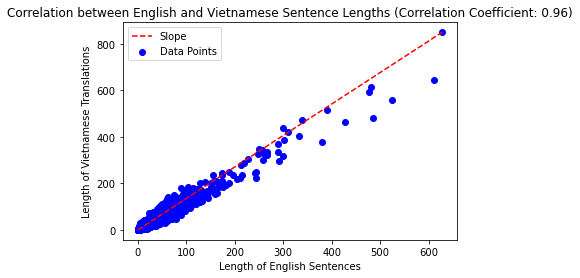

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Calculate lengths and add them as new columns to the DataFrame
English_Length= df['English'].apply(lambda x: len(x.split()))
Vietnamese_Length= df['Vietnamese'].apply(lambda x: len(x.split()))

# Calculate the correlation coefficient
correlation_coefficient = np.corrcoef(English_Length, Vietnamese_Length)[0, 1]

# Scatter plot with different colors for each point
plt.scatter(English_Length, Vietnamese_Length, c='blue', label='Data Points')

# Plot a line representing the slope of the correlation
plt.plot([min(English_Length), max(English_Length)], [min(Vietnamese_Length), max(Vietnamese_Length)], color='red', linestyle='--', label='Slope')

plt.xlabel('Length of English Sentences')
plt.ylabel('Length of Vietnamese Translations')
plt.title('Correlation between English and Vietnamese Sentence Lengths (Correlation Coefficient: {:.2f})'.format(correlation_coefficient))
plt.legend()
plt.show()

**Hypothesis-2:**
The frequency and visualization of the most common words in both English and Vietnamese texts

Dakshitha Mandhalapu-This hypothesis is intriguing because it aims to uncover patterns and differences in word usage between English and Vietnamese, which could provide valuable information for language learners, translators, and researchers interested in cross-linguistic comparisons. By visualizing the most frequent words through bar plots and word clouds, this investigation seeks to highlight prominent vocabulary and potential areas of divergence or similarity between the two languages.Reveals insights into the linguistic characteristics and potential translation challenges between the two languages.

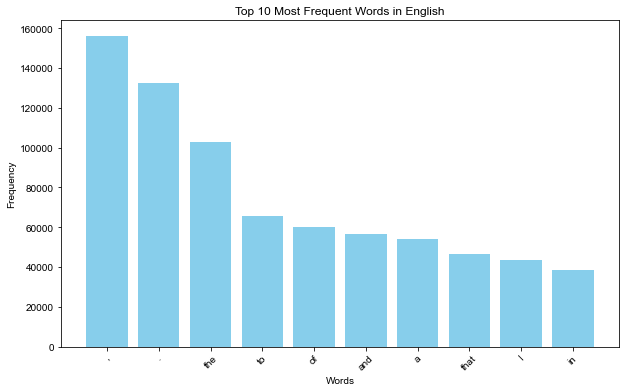

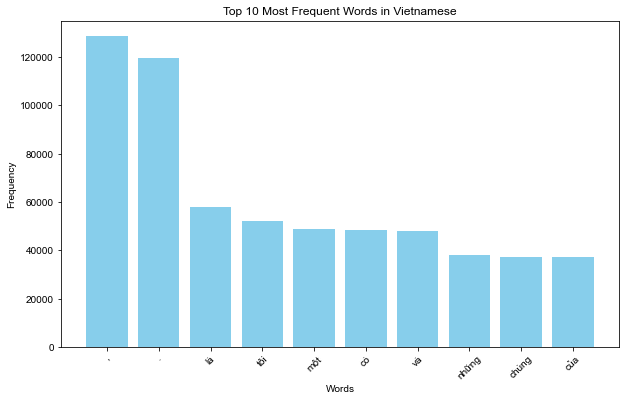

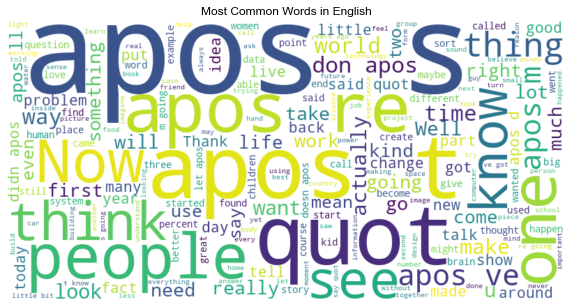

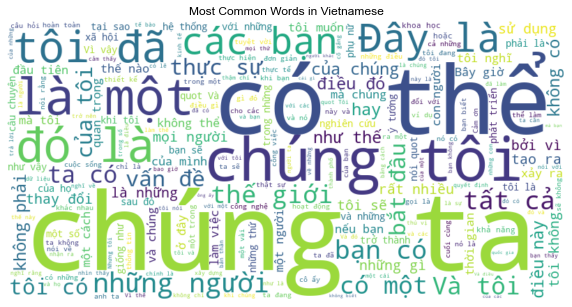

In [ ]:
import matplotlib.pyplot as plt
from collections import Counter
from wordcloud import WordCloud

# Set the font globally for matplotlib
plt.rcParams['font.family'] = 'Arial'

# Preprocess data to get all English and Vietnamese words
english_words = [word for text in df['English'] for word in text.split()]
vietnamese_words = [word for text in df['Vietnamese'] for word in text.split()]

# Visualization 1: Bar plot - Top N most frequent words
def plot_top_words(word_list, language, top_n=10):
    word_counts = Counter(word_list)
    top_words = word_counts.most_common(top_n)
    plt.figure(figsize=(10, 6))
    plt.bar([word[0] for word in top_words], [count[1] for count in top_words], color='skyblue')
    plt.title(f'Top {top_n} Most Frequent Words in {language}')
    plt.xlabel('Words')
    plt.ylabel('Frequency')
    plt.xticks(rotation=45)
    plt.show()

plot_top_words(english_words, 'English', top_n=10)
plot_top_words(vietnamese_words, 'Vietnamese', top_n=10)

# Visualization 2: Word cloud
def generate_wordcloud(word_list, language):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(word_list))
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Most Common Words in {language}')
    plt.axis('off')
    plt.show()

generate_wordcloud(english_words, 'English')
generate_wordcloud(vietnamese_words, 'Vietnamese')


**Hypothesis-3:**
The sentiment polarity distributions of English and French texts

Dakshitha Mandhalapu-This hypothesis is intriguing because it delves into the realm of sentiment analysis across languages, which could unveil cultural nuances or linguistic characteristics influencing sentiment expression. By utilizing kernel density estimation (KDE) plots to visualize the distributions of sentiment polarity scores, this analysis seeks to uncover any disparities or similarities in the overall emotional tones conveyed in English and French texts. Understanding such differences can have implications for various fields, including cross-cultural communication, sentiment-based marketing strategies, and language processing algorithms.And to investigate potential differences in sentiment expression between the two languages.



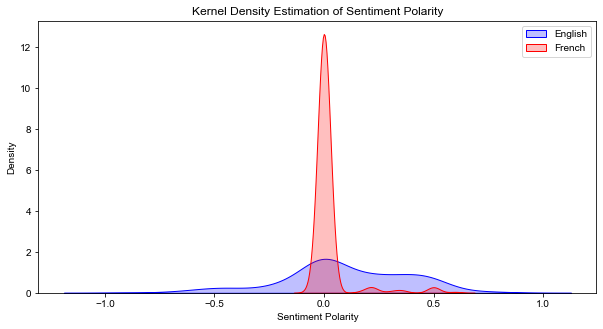

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from textblob import TextBlob
import pandas as pd


# Calculate sentiment polarity for English and French translations
english_sentiments = [TextBlob(text).sentiment.polarity for text in fr_df['English']]
french_sentiments = [TextBlob(text).sentiment.polarity for text in fr_df['French']]

# Set up the figure and axis
plt.figure(figsize=(10, 5))

# Create KDE plots for English and French sentiment distributions
sns.kdeplot(english_sentiments, shade=True, color="b", label="English")
sns.kdeplot(french_sentiments, shade=True, color="r", label="French")

# Set labels and title
plt.xlabel('Sentiment Polarity')
plt.ylabel('Density')
plt.title('Kernel Density Estimation of Sentiment Polarity')

# Add legend
plt.legend()

# Show the plot
plt.show()



**Hypothesis-4:** Word overlaps between English and French translations

Snehitha Chowdary Pallinti-The above visualization is performed by first loading the dataset and extracting their translations. The translations obtained are split into words of two sets english_words and french_words. These sets contain unique words from english and French translations respectively. Now create a venn diagram using venn2 function from matplotlib_venn library. This venn diagram visualizes the overlap between the two sets of words. The number of words that are common to both english and French translations are represented at the intersection part of diagram. The left circle is for English and right is for French. The intersection can provide insights into dataset such as the extent of cognates between both languages, number of loanwords, similarity of the vocabulary usend in translations. I found this hypothesis interesting as it is useful for understanding the extent of shared vocabulary between English and French translations in dataset.

Found cached dataset wino_x (C:/Users/Snehitha Chowdary/.cache/huggingface/datasets/demelin___wino_x/lm_en_fr/1.1.0/0c96a2d6dd4a901c5794f2509e79a42084e3381e4780504ac3cb4149ef7a5391)


  0%|          | 0/1 [00:00<?, ?it/s]

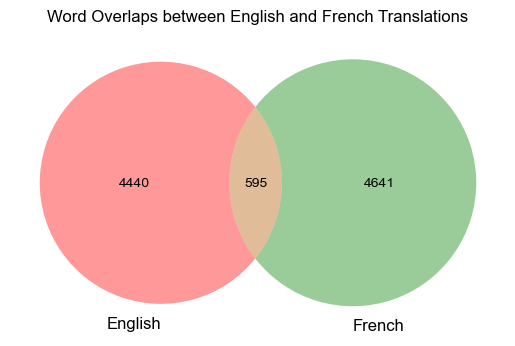

In [ ]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
import pandas as pd
from datasets import load_dataset

# Load the dataset
french_dataset = load_dataset("demelin/wino_x", 'lm_en_fr')
test_data = french_dataset['test']

# Extract English and French translations
english_translations = [sample['context_en'] for sample in test_data]
french_translations = [sample['context_fr'] for sample in test_data]

# Create DataFrame
fr_df = pd.DataFrame({'English': english_translations, 'French': french_translations})

# Only select every other row to avoid long runtimes due to large data
fr_df = fr_df.iloc[::2]

# Split the English and French translations into sets of words
english_words = set(" ".join(fr_df['English']).split())
french_words = set(" ".join(fr_df['French']).split())

# Create a Venn diagram to visualize word overlaps
venn2(subsets=(len(english_words), len(french_words), len(english_words.intersection(french_words))),
      set_labels=('English', 'French'))

plt.title('Word Overlaps between English and French Translations')
plt.show()


**Hypothesis-5:** Parts of speech distribution of English and Vietnamese languages

Snehitha Chowdary Pallinti-A visualization is made based on parts of speech distribution of english and Vietnamese languages from dataset. Firstly libraries are imported and dataset is loaded. Access the dataset and extract sentences from dataset. Perform POS tagging using NLTK library for english and underthesea for Vietnamese. Use a counter to count the frequency of each POS tag in english and Vietnamese POS tag lists obtained. Plot of POS tag distribution for English and Vietnamese are generated. I found this hypothesis interesting as it can be useful for comparing the linguistic structure of the two languages or for analyzing the dataset for machine translation tasks.

[nltk_data] Downloading package punkt to C:\Users\Snehitha
[nltk_data]     Chowdary\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Snehitha
[nltk_data]     Chowdary\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
Found cached dataset mt_eng_vietnamese (C:/Users/Snehitha Chowdary/.cache/huggingface/datasets/mt_eng_vietnamese/iwslt2015-en-vi/1.0.0/53add551a01e9874588066f89d42925f9fad43db347199dad00f7e4b0c905a71)


  0%|          | 0/3 [00:00<?, ?it/s]

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



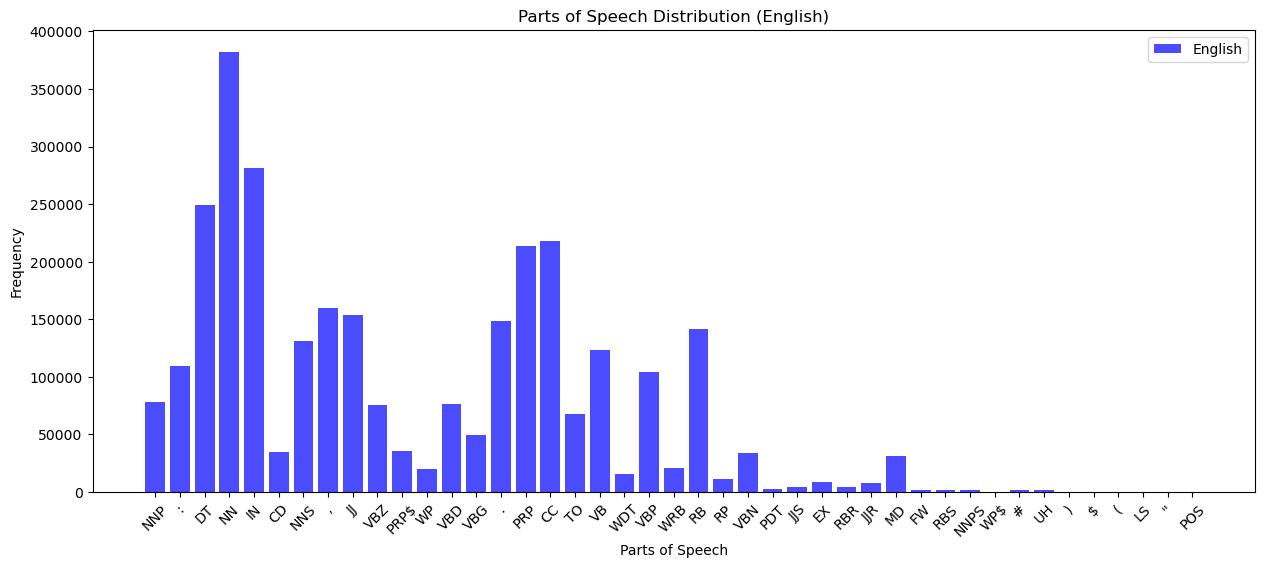

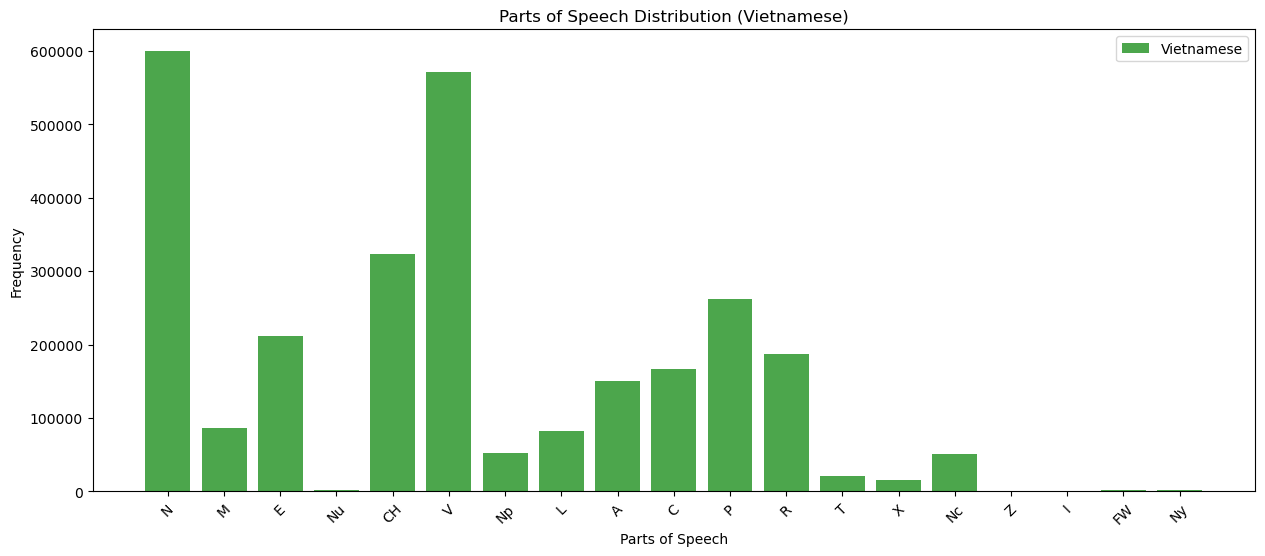

In [ ]:
import nltk
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from underthesea import pos_tag as pos_tag_vn
from collections import Counter
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'sans-serif'
# Download NLTK resources
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

# Load the dataset
from datasets import load_dataset
dataset = load_dataset("mt_eng_vietnamese", "iwslt2015-en-vi")

# Accessing the dataset
train_dataset = dataset["train"]
validation_dataset = dataset["validation"]
test_dataset = dataset["test"]

# Get English and Vietnamese sentences from train, validation, and test sets
english_sentences = []
vietnamese_sentences = []

# Helper function to extract sentences
def extract_sentences(data_split):
    for data in data_split:
        english_sentences.append(data["translation"]["en"])
        vietnamese_sentences.append(data["translation"]["vi"])

# Extract sentences from all splits
extract_sentences(train_dataset)
extract_sentences(validation_dataset)
extract_sentences(test_dataset)

# Function to tokenize and POS tag sentences
from underthesea import pos_tag as pos_tag_vn
def get_pos_tags(sentences, language='english'):
    pos_tags = []
    for sentence in sentences:
        if language == 'english':
            tokens = word_tokenize(sentence)
            pos_tags.extend(pos_tag(tokens))
        elif language == 'vietnamese':
            pos_tags.extend(pos_tag_vn(sentence))
    return pos_tags

# Get POS tags for English sentences
english_pos_tags = get_pos_tags(english_sentences, 'english')
print(english_pos_tags)

# Get POS tags for Vietnamese sentences
vietnamese_pos_tags = get_pos_tags(vietnamese_sentences, 'vietnamese')

# Count POS tags for English
english_pos_counts = Counter(tag for word, tag in english_pos_tags)

# Count POS tags for Vietnamese
vietnamese_pos_counts = Counter(tag for word, tag in vietnamese_pos_tags)

# Plot POS tag distribution for English
plt.figure(figsize=(15, 6))
plt.bar(english_pos_counts.keys(), english_pos_counts.values(), color='blue', alpha=0.7, label='English')
plt.title('Parts of Speech Distribution (English)')
plt.xlabel('Parts of Speech')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.legend()
plt.show()

# Plot POS tag distribution for Vietnamese
plt.figure(figsize=(15, 6))
plt.bar(vietnamese_pos_counts.keys(), vietnamese_pos_counts.values(), color='green', alpha=0.7, label='Vietnamese')
plt.title('Parts of Speech Distribution (Vietnamese)')
plt.xlabel('Parts of Speech')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.legend()
plt.show()

**Hypothesis-6:** English and Vietnamese sentence lengths are distributed similarly

Grishmant - In the box plot visualization, we compare the average length of english and vietnamese sentences. We can see that the median vietnamese sentence is longer than english sentence. The interquartile range is also bigger for vietnamese compared to english. Further, the range is also higher for vietnamese compared to english. From this, we can also infer that vietnamese sentences are more spread out from their median, compared to english whose IQR is smaller. Thus the hypothesis does not stand true

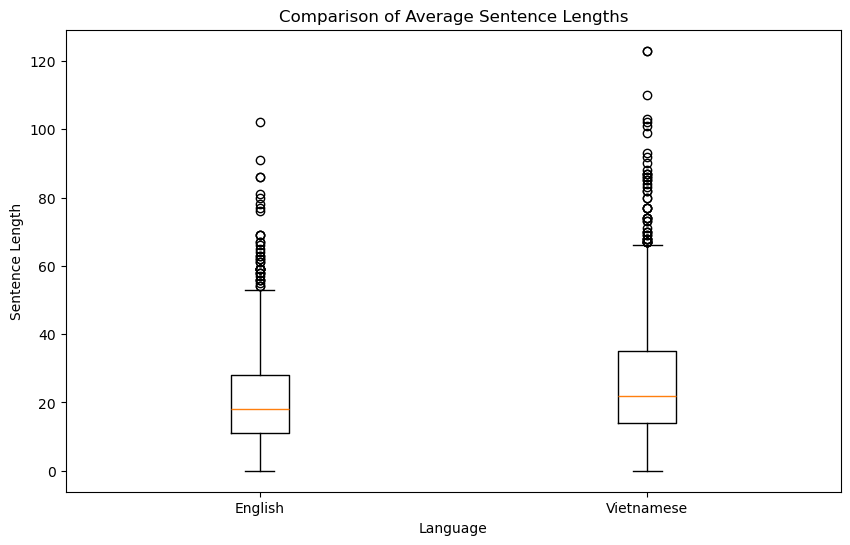

In [ ]:
# viz 1
dataset = load_dataset("mt_eng_vietnamese", "iwslt2015-vi-en", trust_remote_code=True, split="test")
en_len = [len(sent['en'].split()) for sent in dataset['translation']]
vi_len = [len(sent['vi'].split()) for sent in dataset['translation']]

# box plot
plt.figure(figsize=(10, 6))
plt.boxplot([en_len, vi_len], labels=['English', 'Vietnamese'])
plt.title('Comparison of Average Sentence Lengths')
plt.xlabel('Language')
plt.ylabel('Sentence Length')
plt.show()

**Hypothesis-6:** English sentences use more stop words than Vietnamese sentences

Grishmant - In the bar chart, we compare the average stop word usage in a sentence for both english and vietnamese. We can see that english employs more stop word usage compared to vietnamese. From the earlier box plot, we know that the average sentence length of english is lower than vietnamese. And here we see that despite having relatively shorter sentence lengths, english uses more stop words. Therefore, the hypothesis is not false

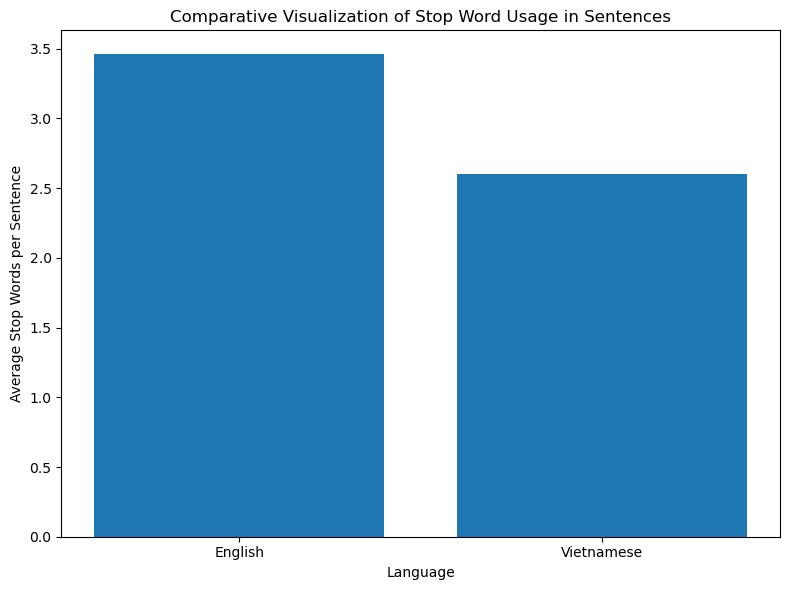

In [ ]:
# viz 2
en_text = [item['en'] for item in dataset['translation']]
vi_text = [item['vi'] for item in dataset['translation']]
en_stopwords = ['the', 'a', 'and', 'to', 'in', 'is', 'that', 'it', 'for', 'on']
vi_stopwords = ['là', 'và', 'của', 'trong', 'cho', 'này', 'với', 'có', 'không', 'từ']

en_stop_counts = [sum(word in en_stopwords for word in sentence.split()) for sentence in en_text]
en_avg_stop_words = sum(en_stop_counts) / len(en_text)

vi_stop_counts = [sum(word in vi_stopwords for word in sentence.split()) for sentence in vi_text]
vi_avg_stop_words = sum(vi_stop_counts) / len(vi_text)

fig, ax = plt.subplots(figsize=(8, 6))

languages = ['English', 'Vietnamese']
avg_stop_words = [en_avg_stop_words, vi_avg_stop_words]

ax.bar(languages, avg_stop_words)
ax.set_xlabel('Language')
ax.set_ylabel('Average Stop Words per Sentence')
ax.set_title('Comparative Visualization of Stop Word Usage in Sentences')

plt.tight_layout()
plt.show()

## ML Analysis

Grishmant - Here, we compute the BLEU Scores for the Vietnamese-English dataset after generating LLM translations using the MBart model. The results are then visualized to show the distribution of similarity scores

### mBart 50 many to many BLEU score

In [ ]:
from transformers import MBartForConditionalGeneration, MBart50TokenizerFast
from datasets import load_dataset, load_metric
import sacrebleu

In [ ]:
model = MBartForConditionalGeneration.from_pretrained("facebook/mbart-large-50-many-to-many-mmt")
tokenizer = MBart50TokenizerFast.from_pretrained("facebook/mbart-large-50-many-to-many-mmt")
dataset = load_dataset("mt_eng_vietnamese", "iwslt2015-vi-en", trust_remote_code=True, split="train")

In [ ]:
source_texts = [example["en"] for example in dataset['translation']]
target_texts = [example["vi"] for example in dataset['translation']]

source_encodings = tokenizer(source_texts, max_length=1024, padding=True, truncation=True, return_tensors="pt")
target_encodings = tokenizer(target_texts, max_length=1024, padding=True, truncation=True, return_tensors="pt")

source_lang = "en_XX"
target_lang = "vi_VN"

In [ ]:
# Example input and output from english to vietnamese

example_input = "Hello, how are you?"

input_ids = tokenizer.encode(example_input, return_tensors="pt")

output_ids = model.generate(input_ids, forced_bos_token_id=tokenizer.lang_code_to_id[target_lang])


translation = tokenizer.decode(output_ids[0], skip_special_tokens=True)
print(f"Input: {example_input}")
print(f"Translation: {translation}")

Input: Hello, how are you?
Translation: Xin chào, mọi chuyện như thế nào?


In [ ]:
import sacrebleu
from transformers import MBartForConditionalGeneration, MBart50TokenizerFast
from datasets import load_metric, load_dataset


# Define evaluation metric
bleu_metric = sacrebleu.corpus_bleu

# Load dataset
#dataset = load_dataset("iwslt2015", "vi-en", split="train")

predictions = []
references = []

pred_size, counter = 100, 0

for example in dataset["translation"]:
    input_text = example["en"]
    reference_text = example["vi"]

    # Tokenize inputs
    input_ids = tokenizer(input_text, return_tensors="pt").input_ids.to(model.device)
    decoder_start_token_id = tokenizer.lang_code_to_id["vi_VN"]

    # Generate translation using beam search with increased beam size
    generated_ids = model.generate(input_ids, forced_bos_token_id=decoder_start_token_id, num_beams=8, max_length=128, early_stopping=True)

    prediction = tokenizer.decode(generated_ids[0], skip_special_tokens=True)

    predictions.append(prediction)
    references.append([reference_text])

    counter += 1
    if counter == pred_size:
        break

# Calculate overall BLEU score
overall_bleu_score = bleu_metric(predictions, references)
print(f"BLEU score: {overall_bleu_score.score}")


BLEU score: 80.70557274927978


In [ ]:
import sacrebleu

bleu_metric = load_metric("sacrebleu")

predictions = []
references = []
bleu_scores = []

pred_size, counter = 100, 0

for example in dataset["translation"]:
    input_ids = tokenizer.encode(example["en"], return_tensors="pt")
    output_ids = model.generate(input_ids, forced_bos_token_id=tokenizer.lang_code_to_id[target_lang])
    prediction = tokenizer.decode(output_ids[0], skip_special_tokens=True)
    reference = example["vi"]

    predictions.append(prediction)
    references.append([reference])

    # Calculate bleu score for the current sentence pair
    bleu_score = sacrebleu.corpus_bleu([prediction], [[reference]]).score

    bleu_scores.append(bleu_score)

    counter += 1
    if counter == pred_size: break

# Calculate overall BLEU score
overall_bleu_score = bleu_metric.compute(predictions=predictions, references=references)
print(f"BLEU score: {overall_bleu_score['score']}")

C:\Users\india\AppData\Local\Temp/ipykernel_12032/2342126461.py:3: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  bleu_metric = load_metric("sacrebleu")
C:\Users\india\anaconda3\lib\site-packages\datasets\load.py:756: FutureWarning: The repository for sacrebleu contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.18.0/metrics/sacrebleu/sacrebleu.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


BLEU score: 32.16426804985012


Grishmant - The relationship between length of the sentences and similarity score is obtained below. The necessary libraries are imported and lengths of sentences in english and vietnamese are obtained. A scatter plot is created to represent the plot between sentence length and similarity score. This can be useful to understand if there is any correlation between sentence length and quality of translation based on similarity score. The BLEU score obtained is 39.44300501309953.

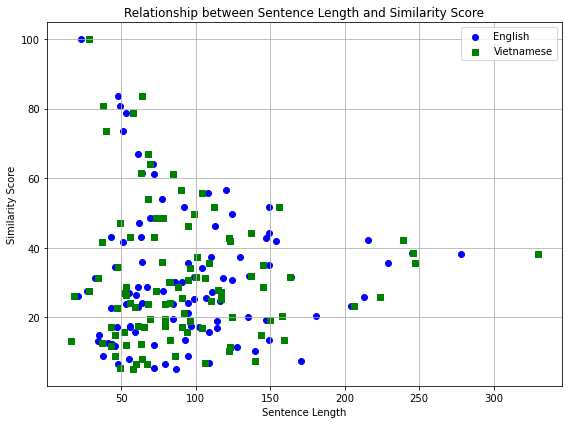

In [ ]:
import matplotlib.pyplot as plt
import numpy as np



# Calculate length of each sentence
english_lengths = [len(sentence['en']) for sentence in dataset['translation']]
vietnamese_lengths = [len(sentence['vi']) for sentence in dataset['translation']]


plt.figure(figsize=(8, 6))
plt.scatter(english_lengths[:pred_size], bleu_scores, label='English', color='blue', marker='o')
plt.scatter(vietnamese_lengths[:pred_size], bleu_scores, label='Vietnamese', color='green', marker='s')


plt.xlabel('Sentence Length')
plt.ylabel('Similarity Score')
plt.title('Relationship between Sentence Length and Similarity Score')
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.show()

## French Dataset Analysis using Bloom API - Shayan Rasheed


In [ ]:
notebook_login()

In [ ]:
inference = InferenceApi("bigscience/bloom",token=HfFolder.get_token())

def infer(prompt,
          max_length,
          top_k = 0,
          num_beams = 0,
          no_repeat_ngram_size = 2,
          top_p = 0.9,
          seed=42,
          temperature=0.7,
          greedy_decoding = False,
          return_full_text = False):


    top_k = None if top_k == 0 else top_k
    do_sample = False if num_beams > 0 else not greedy_decoding
    num_beams = None if (greedy_decoding or num_beams == 0) else num_beams
    no_repeat_ngram_size = None if num_beams is None else no_repeat_ngram_size
    top_p = None if num_beams else top_p
    early_stopping = None if num_beams is None else num_beams > 0

    params = {
        "max_new_tokens": max_length,
        "top_k": top_k,
        "top_p": top_p,
        "temperature": temperature,
        "do_sample": do_sample,
        "seed": seed,
        "early_stopping":early_stopping,
        "no_repeat_ngram_size":no_repeat_ngram_size,
        "num_beams":num_beams,
        "return_full_text":return_full_text
    }

    s = time.time()
    response = inference(prompt, params=params)
    #print(response)
    proc_time = time.time()-s
    #print(f"Processing time was {proc_time} seconds")
    return response

In [ ]:
def apply_infer(row):
    output = infer(f"French: {row['French']} English:", len(row['English']) + 3)
    return output

fr_df['LLM_Translation'] = fr_df.apply(apply_infer, axis=1)

display(fr_df)

,en,fr,LLM_Translation
100,"Then, as long as there was a ray of light, I s...","Alors, tant qu’il y avait une lueur de jour, j...","So, as long as there was a light of day, I sta..."
101,"When it was quite dark, and the dogs of the ne...","Lorsqu’il faisait noir, que les chiens de la f...","When it was dark, the dogs of the nearby farm ..."
102,Mother had begun to get supper ready.,Ma mère avait commencé de préparer le repas.,My mother had begun to prepare the meal.
103,"I climbed three steps of the attic stairs, sat...",Je montais trois marches de l’escalier du gren...,I climbed three steps from the stairway of the...
104,But some one has come who has taken from me th...,Mais quelqu’un est venu qui m’a enlevé à tous ...,But someone came who took me away from all the...
...,...,...,...
195,"At two o'clock in the afternoon next day, in t...","À deux heures de l’après-midi, le lendemain, l...","At two o'clock in the afternoon, the next day,..."
196,There is no smell of brine or tar as on a boat...,"On n’y sent pas la saumure ni le cambouis, com...","It does not smell brine or camboo, as on a fis..."
197,"As the end of the year is drawing near, the ex...","On a distribué, car la fin de l’année approche...","The composition books were distributed, as the..."
198,And while M. Seurel is setting problems on the...,"Et, pendant que M. Seurel écrit au tableau l’é...",And while Mr. Seurel writes on the table of pr...


### Evaluating LLM accuracy using BLEU SCORE

In [ ]:
def compute_bleu(row):
    reference = [row['en']]
    candidate = [row['LLM_Translation']]
    return sacrebleu.corpus_bleu(candidate, [reference]).score

fr_df['bleu_score'] = fr_df.apply(compute_bleu, axis=1)
display(fr_df)

,en,fr,LLM_Translation,bleu_score,rouge_score
100,"Then, as long as there was a ray of light, I s...","Alors, tant qu’il y avait une lueur de jour, j...","So, as long as there was a light of day, I sta...",30.982990,"{'rouge-1': {'r': 0.6216216216216216, 'p': 0.5..."
101,"When it was quite dark, and the dogs of the ne...","Lorsqu’il faisait noir, que les chiens de la f...","When it was dark, the dogs of the nearby farm ...",23.706174,"{'rouge-1': {'r': 0.5769230769230769, 'p': 0.6..."
102,Mother had begun to get supper ready.,Ma mère avait commencé de préparer le repas.,My mother had begun to prepare the meal.,19.070828,"{'rouge-1': {'r': 0.42857142857142855, 'p': 0...."
103,"I climbed three steps of the attic stairs, sat...",Je montais trois marches de l’escalier du gren...,I climbed three steps from the stairway of the...,28.889424,"{'rouge-1': {'r': 0.7222222222222222, 'p': 0.7..."
104,But some one has come who has taken from me th...,Mais quelqu’un est venu qui m’a enlevé à tous ...,But someone came who took me away from all the...,6.734395,"{'rouge-1': {'r': 0.38461538461538464, 'p': 0...."
...,...,...,...,...,...
195,"At two o'clock in the afternoon next day, in t...","À deux heures de l’après-midi, le lendemain, l...","At two o'clock in the afternoon, the next day,...",29.415187,"{'rouge-1': {'r': 0.5238095238095238, 'p': 0.5..."
196,There is no smell of brine or tar as on a boat...,"On n’y sent pas la saumure ni le cambouis, com...","It does not smell brine or camboo, as on a fis...",14.587229,"{'rouge-1': {'r': 0.4827586206896552, 'p': 0.4..."
197,"As the end of the year is drawing near, the ex...","On a distribué, car la fin de l’année approche...","The composition books were distributed, as the...",24.018433,"{'rouge-1': {'r': 0.35294117647058826, 'p': 0...."
198,And while M. Seurel is setting problems on the...,"Et, pendant que M. Seurel écrit au tableau l’é...",And while Mr. Seurel writes on the table of pr...,7.850507,"{'rouge-1': {'r': 0.5277777777777778, 'p': 0.5..."


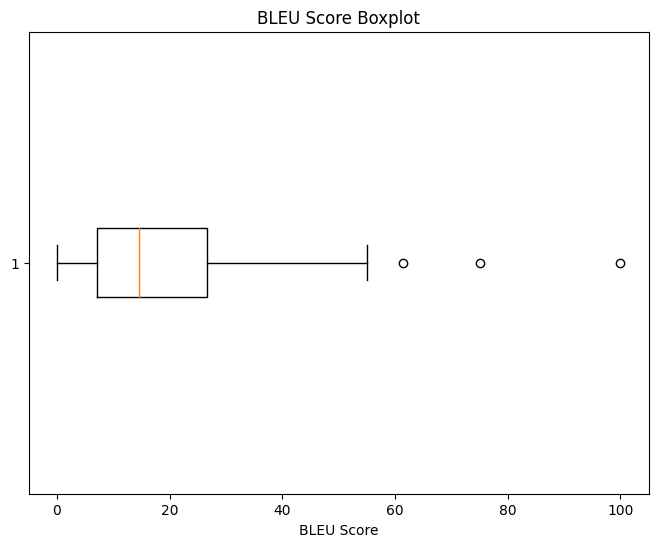

In [ ]:
plt.figure(figsize=(8, 6))
plt.boxplot(fr_df['bleu_score'], vert=False)
plt.title('BLEU Score Boxplot')
plt.xlabel('BLEU Score')
plt.show()

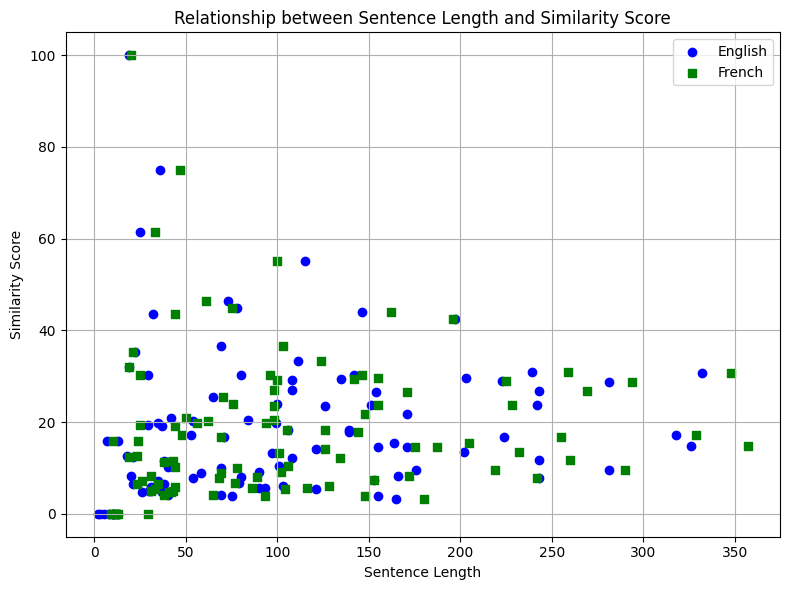

In [ ]:
english_lengths = [len(row['en']) for index, row in fr_df.iterrows()]
french_lengths = [len(row['fr']) for index, row in fr_df.iterrows()]


plt.figure(figsize=(8, 6))
plt.scatter(english_lengths, fr_df['bleu_score'], label='English', color='blue', marker='o')
plt.scatter(french_lengths, fr_df['bleu_score'], label='French', color='green', marker='s')


plt.xlabel('Sentence Length')
plt.ylabel('Similarity Score')
plt.title('Relationship between Sentence Length and Similarity Score')
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.show()

In [ ]:
fr_df['bleu_score'].median()

14.67061544276568

In [ ]:
fr_df['bleu_score'].mean()

18.523374603407348

### Analysis of BLEU Results

The overall results of the BLEU Scores for the LLM Translation were relatively low. For instance, consider the following example:

In [ ]:
fr_df['en'].iloc[1]

'When it was quite dark, and the dogs of the neighbouring farm began to howl and a light was seen at the window of our little kitchen, then I went home.'

In [ ]:
fr_df['LLM_Translation'].iloc[1]

'When it was dark, the dogs of the nearby farm began to scream and the tile of our little kitchen was silting, I finally came home.'

In [ ]:
fr_df['bleu_score'].iloc[1]

23.706173812439708

As you can see, the meaning of the LLM generated translation and the reference translation are similar, but the wording is slightly different. This results in fewer matching n-grams, which is what the BLEU Score is computed based on. This is the cause of the lower BLEU Score for the translations overall.

From this, we can see that the distribution of BLEU Scores is increadibly spread out with no discernible pattern, as there are both sentences with very high similarity scores and low similarity scores. We plan on further looking into this by computing different metrics for similarity such as ROUGE Score and BERT Score to see if there are any notable differences. We also plan to examine the sentences which have lower/higher scores and see if there are any similarities between them.

### Computing ROUGE

In [ ]:
def compute_rouge(row):
    prediction = row['LLM_Translation']
    reference = row['en']

    rouge = Rouge()
    scores = rouge.get_scores(prediction, reference)
    return scores[0]

In [ ]:
fr_df['rouge_score'] = fr_df.apply(compute_rouge, axis=1)
display(fr_df)

,en,fr,LLM_Translation,bleu_score,rouge_score
100,"Then, as long as there was a ray of light, I s...","Alors, tant qu’il y avait une lueur de jour, j...","So, as long as there was a light of day, I sta...",1.103598,"{'rouge-1': {'r': 0.6216216216216216, 'p': 0.5..."
101,"When it was quite dark, and the dogs of the ne...","Lorsqu’il faisait noir, que les chiens de la f...","When it was dark, the dogs of the nearby farm ...",1.693410,"{'rouge-1': {'r': 0.5769230769230769, 'p': 0.6..."
102,Mother had begun to get supper ready.,Ma mère avait commencé de préparer le repas.,My mother had begun to prepare the meal.,4.767707,"{'rouge-1': {'r': 0.42857142857142855, 'p': 0...."
103,"I climbed three steps of the attic stairs, sat...",Je montais trois marches de l’escalier du gren...,I climbed three steps from the stairway of the...,1.031202,"{'rouge-1': {'r': 0.7222222222222222, 'p': 0.7..."
104,But some one has come who has taken from me th...,Mais quelqu’un est venu qui m’a enlevé à tous ...,But someone came who took me away from all the...,2.839839,"{'rouge-1': {'r': 0.38461538461538464, 'p': 0...."
...,...,...,...,...,...
195,"At two o'clock in the afternoon next day, in t...","À deux heures de l’après-midi, le lendemain, l...","At two o'clock in the afternoon, the next day,...",1.579046,"{'rouge-1': {'r': 0.5238095238095238, 'p': 0.5..."
196,There is no smell of brine or tar as on a boat...,"On n’y sent pas la saumure ni le cambouis, com...","It does not smell brine or camboo, as on a fis...",1.304348,"{'rouge-1': {'r': 0.4827586206896552, 'p': 0.4..."
197,"As the end of the year is drawing near, the ex...","On a distribué, car la fin de l’année approche...","The composition books were distributed, as the...",2.923638,"{'rouge-1': {'r': 0.35294117647058826, 'p': 0...."
198,And while M. Seurel is setting problems on the...,"Et, pendant que M. Seurel écrit au tableau l’é...",And while Mr. Seurel writes on the table of pr...,2.322403,"{'rouge-1': {'r': 0.5277777777777778, 'p': 0.5..."


#### ROUGE-1 Scores

In [ ]:
precision_scores = [row['rouge-1']['p'] for row in fr_df['rouge_score']]
recall_scores = [row['rouge-1']['r'] for row in fr_df['rouge_score']]
f1_scores = [row['rouge-1']['f'] for row in fr_df['rouge_score']]

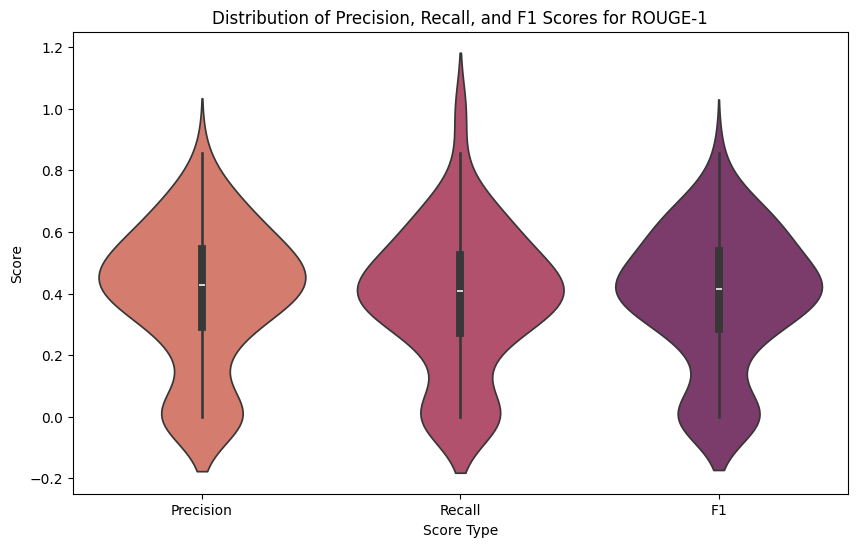

In [ ]:
data = pd.DataFrame({
    'Score Type': ['Precision'] * len(precision_scores) + ['Recall'] * len(recall_scores) + ['F1'] * len(f1_scores),
    'Score': precision_scores + recall_scores + f1_scores
})

plt.figure(figsize=(10, 6))
sns.violinplot(x="Score Type", y="Score", data=data, palette="flare", hue="Score Type")
plt.title('Distribution of Precision, Recall, and F1 Scores for ROUGE-1')
plt.ylabel('Score')
plt.show()

#### ROUGE-2 Scores

In [ ]:
precision_scores = [row['rouge-2']['p'] for row in fr_df['rouge_score']]
recall_scores = [row['rouge-2']['r'] for row in fr_df['rouge_score']]
f1_scores = [row['rouge-2']['f'] for row in fr_df['rouge_score']]

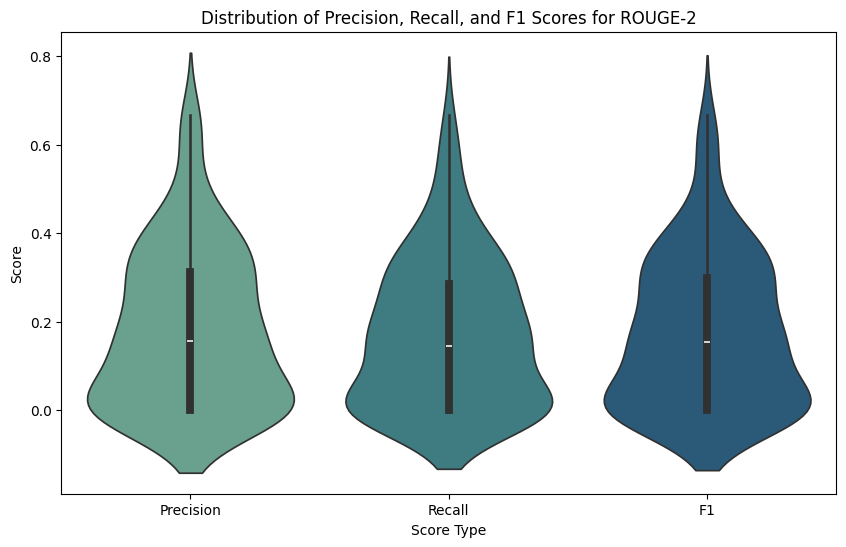

In [ ]:
data = pd.DataFrame({
    'Score Type': ['Precision'] * len(precision_scores) + ['Recall'] * len(recall_scores) + ['F1'] * len(f1_scores),
    'Score': precision_scores + recall_scores + f1_scores
})

plt.figure(figsize=(10, 6))
sns.violinplot(x="Score Type", y="Score", data=data, palette="crest", hue="Score Type")
plt.title('Distribution of Precision, Recall, and F1 Scores for ROUGE-2')
plt.ylabel('Score')
plt.show()

#### ROUGE-L Scores

In [ ]:
precision_scores = [row['rouge-l']['p'] for row in fr_df['rouge_score']]
recall_scores = [row['rouge-l']['r'] for row in fr_df['rouge_score']]
f1_scores = [row['rouge-l']['f'] for row in fr_df['rouge_score']]

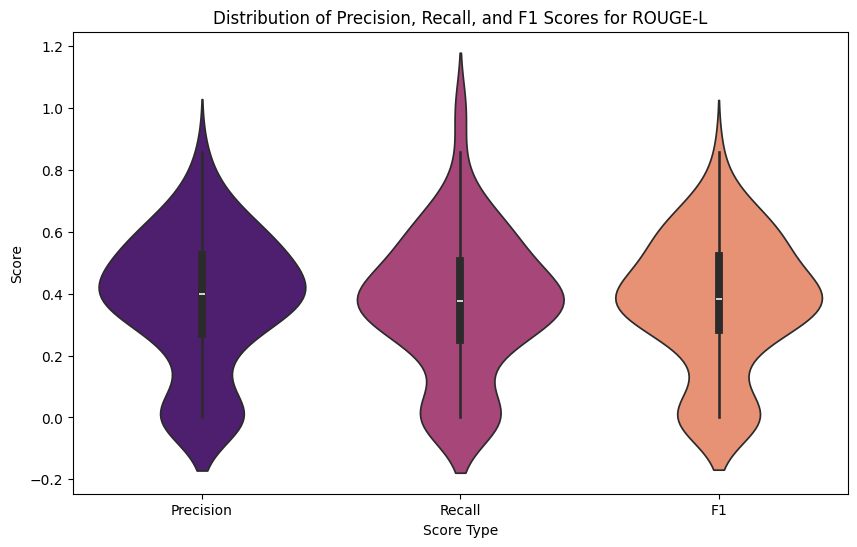

In [ ]:
data = pd.DataFrame({
    'Score Type': ['Precision'] * len(precision_scores) + ['Recall'] * len(recall_scores) + ['F1'] * len(f1_scores),
    'Score': precision_scores + recall_scores + f1_scores
})

plt.figure(figsize=(10, 6))
sns.violinplot(x="Score Type", y="Score", data=data, palette="magma", hue="Score Type")
plt.title('Distribution of Precision, Recall, and F1 Scores for ROUGE-L')
plt.ylabel('Score')
plt.show()

### Analyzing ROUGE Score

From this, we can see that the ROUGE-1 Scores were higher than that of the BLEU Scores, with medians of about 0.4 (highest is 1) for ROUGE-1 Score precision, recall, and F1; and 14 (highest is 100) for BLEU Score.

The ROUGE-1 Score measures the proportion of overlapping unigrams (single words) between the reference (ground truth) summary and the generated summary. This would explain why the ROUGE-1 Scores would be higher since the LLM Translations commonly contained similar words to that of the reference translation with some differences in word choice and/or order. As mentioned previosuly, BLEU Scores are the measure of matching n-grams, which is a much stricter measurement on how close the LLM translation is to the reference.

ROUGE-2 scores instead take bigrams into consideration, which are sequences of two adjacent words. The overall scores for ROUGE-2 was lower than ROUGE-1, but higher than BLEU. This is, again, likely due to the slight differences in wording present in the LLM Translations.

### Calculating BERT Score

In [ ]:
def compute_bert(row):
    reference = [row['en']]
    candidate = [row['LLM_Translation']]
    return bert_score.score(candidate, reference, lang='en')

In [ ]:
fr_df['bert_score'] = fr_df.apply(compute_bert, axis=1)

In [ ]:
display(fr_df)

,en,fr,LLM_Translation,bleu_score,rouge_score,bert_score
100,"Then, as long as there was a ray of light, I s...","Alors, tant qu’il y avait une lueur de jour, j...","So, as long as there was a light of day, I sta...",30.982990,"{'rouge-1': {'r': 0.6216216216216216, 'p': 0.5...","([tensor(0.9255)], [tensor(0.9212)], [tensor(0..."
101,"When it was quite dark, and the dogs of the ne...","Lorsqu’il faisait noir, que les chiens de la f...","When it was dark, the dogs of the nearby farm ...",23.706174,"{'rouge-1': {'r': 0.5769230769230769, 'p': 0.6...","([tensor(0.9305)], [tensor(0.9276)], [tensor(0..."
102,Mother had begun to get supper ready.,Ma mère avait commencé de préparer le repas.,My mother had begun to prepare the meal.,19.070828,"{'rouge-1': {'r': 0.42857142857142855, 'p': 0....","([tensor(0.9506)], [tensor(0.9558)], [tensor(0..."
103,"I climbed three steps of the attic stairs, sat...",Je montais trois marches de l’escalier du gren...,I climbed three steps from the stairway of the...,28.889424,"{'rouge-1': {'r': 0.7222222222222222, 'p': 0.7...","([tensor(0.9452)], [tensor(0.9336)], [tensor(0..."
104,But some one has come who has taken from me th...,Mais quelqu’un est venu qui m’a enlevé à tous ...,But someone came who took me away from all the...,6.734395,"{'rouge-1': {'r': 0.38461538461538464, 'p': 0....","([tensor(0.9453)], [tensor(0.9386)], [tensor(0..."
...,...,...,...,...,...,...
195,"At two o'clock in the afternoon next day, in t...","À deux heures de l’après-midi, le lendemain, l...","At two o'clock in the afternoon, the next day,...",29.415187,"{'rouge-1': {'r': 0.5238095238095238, 'p': 0.5...","([tensor(0.9264)], [tensor(0.9302)], [tensor(0..."
196,There is no smell of brine or tar as on a boat...,"On n’y sent pas la saumure ni le cambouis, com...","It does not smell brine or camboo, as on a fis...",14.587229,"{'rouge-1': {'r': 0.4827586206896552, 'p': 0.4...","([tensor(0.9177)], [tensor(0.9154)], [tensor(0..."
197,"As the end of the year is drawing near, the ex...","On a distribué, car la fin de l’année approche...","The composition books were distributed, as the...",24.018433,"{'rouge-1': {'r': 0.35294117647058826, 'p': 0....","([tensor(0.9296)], [tensor(0.9120)], [tensor(0..."
198,And while M. Seurel is setting problems on the...,"Et, pendant que M. Seurel écrit au tableau l’é...",And while Mr. Seurel writes on the table of pr...,7.850507,"{'rouge-1': {'r': 0.5277777777777778, 'p': 0.5...","([tensor(0.9139)], [tensor(0.9060)], [tensor(0..."


In [ ]:
print(compute_bert(fr_df.iloc[1])[0].item())

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


0.9304547309875488


In [ ]:
precision_scores = [row[0].item() for row in fr_df['bert_score']]
recall_scores = [row[1].item() for row in fr_df['bert_score']]
f1_scores = [row[2].item() for row in fr_df['bert_score']]

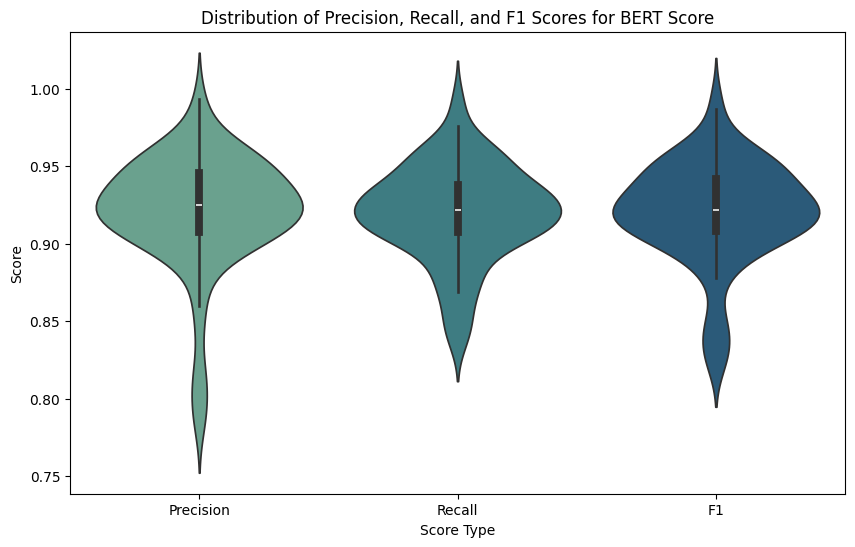

In [ ]:
data = pd.DataFrame({
    'Score Type': ['Precision'] * len(precision_scores) + ['Recall'] * len(recall_scores) + ['F1'] * len(f1_scores),
    'Score': precision_scores + recall_scores + f1_scores
})

plt.figure(figsize=(10, 6))
sns.violinplot(x="Score Type", y="Score", data=data, palette="crest", hue="Score Type")
plt.title('Distribution of Precision, Recall, and F1 Scores for BERT Score')
plt.ylabel('Score')
plt.show()

### Analyzing BERT Score

BERT Score is a translation evaluation metric that considers semantic similarity by comparing embeddings of text segments rather than relying solely on exact word matches. In this way, it much more closely matches human judgement compared to other metrics. This can clearly be seen from the results of the calculation, as the BERT Scores were overall very high compared to the other two metrics.

Based on the results from each of the three metrics, it can be seen that the LLM Translations did succeed in capturing the meaning of the original text, as shown by the high bert score. But it did not manage to closely match the reference translations in the dataset, as shown by the low BLEU Score. More work with fine tuning could be done in the future to potentially increase the scores for BLEU and ROUGE.

# Model performance

### mBart 50 many-to-many - Grishmant

In [ ]:
from transformers import MBartTokenizer, TrainingArguments, Trainer, AdapterConfig, AutoAdapterModel, MBartForConditionalGeneration
from datasets import load_dataset
from sacrebleu import corpus_bleu
from rouge_score import rouge_scorer
import torch
import matplotlib.pyplot as plt

In [ ]:
# Load dataset
dataset = load_dataset("mt_eng_vietnamese.py", "iwslt2015-vi-en", trust_remote_code=True, split="test")

tokenizer = MBartTokenizer.from_pretrained("facebook/mbart-large-50-many-to-many-mmt")

def tokenize(examples):
    inputs = [ex["en"] for ex in examples["translation"]]
    targets = [ex["vi"] for ex in examples["translation"]]
    input_ids = tokenizer(inputs, max_length=1024, truncation=True, padding="max_length", return_tensors="pt")["input_ids"]
    target_ids = tokenizer(targets, max_length=1024, truncation=True, padding="max_length", return_tensors="pt")["input_ids"]
    return {"input_ids": input_ids, "labels": target_ids}

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'MBart50Tokenizer'. 
The class this function is called from is 'MBartTokenizer'.


In [ ]:
tokenized_datasets = dataset.map(tokenize, batched=True, remove_columns=dataset.column_names)

# Load baseline mBart model
baseline_model = MBartForConditionalGeneration.from_pretrained("facebook/mbart-large-50-many-to-many-mmt")

Map: 100%|██████████| 1269/1269 [00:00<00:00, 1679.77 examples/s]


In [ ]:
# baseline

test_dataset = tokenized_datasets
# input_ids = torch.stack(test_dataset["input_ids"])
# labels = torch.stack(test_dataset["labels"])
input_ids = torch.stack([torch.tensor(tensor) for tensor in test_dataset["input_ids"]])
labels = torch.stack([torch.tensor(tensor) for tensor in test_dataset["labels"]])


output = baseline_model(input_ids, labels=labels)[0]
baseline_preds = tokenizer.batch_decode(output.argmax(dim=-1), skip_special_tokens=True)
baseline_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

#bleu
baseline_bleu = corpus_bleu(baseline_preds, [baseline_labels]).score
baseline_bleu = baseline_bleu / 100

#rouge
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
baseline_rouge = scorer.score_pairs(baseline_labels, baseline_preds)

print("Baseline mBart Model:")
print(f"BLEU Score: {baseline_bleu:.2f}")
print(f"ROUGE-1: Recall: {baseline_rouge['rouge1'].recall:.2f}, Precision: {baseline_rouge['rouge1'].precision:.2f}, F-1 Score: {baseline_rouge['rouge1'].fmeasure:.2f}")
print(f"ROUGE-2: Recall: {baseline_rouge['rouge2'].recall:.2f}, Precision: {baseline_rouge['rouge2'].precision:.2f}, F-1 Score: {baseline_rouge['rouge2'].fmeasure:.2f}")
print(f"ROUGE-L: Recall: {baseline_rouge['rougeL'].recall:.2f}, Precision: {baseline_rouge['rougeL'].precision:.2f}, F-1 Score: {baseline_rouge['rougeL'].fmeasure:.2f}")

Baseline mBart Model:
BLEU Score: 0.47
ROUGE-1: Recall: 0.66, Precision: 0.67, F-1 Score: 0.66
ROUGE-2: Recall: 0.61, Precision: 0.63, F-1 Score: 0.62
ROUGE-L: Recall: 0.65, Precision: 0.67, F-1 Score: 0.66


In [ ]:
# adapter model
adapter_config = AdapterConfig.load("adapter_config.json")
adapter_model = AutoAdapterModel.get("facebook/mbart-large-50-many-to-many-mmt", adapter_config)

adapter_model.model.eval()
adapter_results = adapter_model.model.generate(test_dataset["input_ids"], max_length=1024, num_beams=4, early_stopping=True)
adapter_preds = tokenizer.batch_decode(adapter_results, skip_special_tokens=True)
adapter_labels = tokenizer.batch_decode(test_dataset["labels"], skip_special_tokens=True)

#bleu
adapter_bleu = corpus_bleu(adapter_preds, [adapter_labels]).score
adapter_bleu = adapter_bleu / 100

#rouge
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
adapter_rouge = scorer.score_pairs(adapter_labels, adapter_preds)

print("Adapter mBart Model:")
print(f"BLEU Score: {adapter_bleu:.2f}")
print(f"ROUGE-1: Recall: {adapter_rouge['rouge1'].recall:.2f}, Precision: {adapter_rouge['rouge1'].precision:.2f}, F-1 Score: {adapter_rouge['rouge1'].fmeasure:.2f}")
print(f"ROUGE-2: Recall: {adapter_rouge['rouge2'].recall:.2f}, Precision: {adapter_rouge['rouge2'].precision:.2f}, F-1 Score: {adapter_rouge['rouge2'].fmeasure:.2f}")
print(f"ROUGE-L: Recall: {adapter_rouge['rougeL'].recall:.2f}, Precision: {adapter_rouge['rougeL'].precision:.2f}, F-1 Score: {adapter_rouge['rougeL'].fmeasure:.2f}")

Adapter mBart Model:
BLEU Score: 0.51
ROUGE-1: Recall: 0.70, Precision: 0.70, F-1 Score: 0.70
ROUGE-2: Recall: 0.64, Precision: 0.65, F-1 Score: 0.64
ROUGE-L: Recall: 0.69, Precision: 0.70, F-1 Score: 0.69


In [ ]:
# looking at results based on sentence length and effect on accuracy scores
# split sentences by length
def split_by_length(preds, labels, threshold=20):
    short_preds, short_labels = [], []
    long_preds, long_labels = [], []
    for pred, label in zip(preds, labels):
        if len(pred.split()) <= threshold:
            short_preds.append(pred)
            short_labels.append(label)
        else:
            long_preds.append(pred)
            long_labels.append(label)
    return short_preds, short_labels, long_preds, long_labels

In [ ]:
# split the predictions and labels into short and long sentences
baseline_short_preds, baseline_short_labels, baseline_long_preds, baseline_long_labels = split_by_length(baseline_preds, baseline_labels)
adapter_short_preds, adapter_short_labels, adapter_long_preds, adapter_long_labels = split_by_length(adapter_preds, adapter_labels)

# scores
baseline_short_bleu = corpus_bleu([baseline_short_preds], [baseline_short_labels]).score
baseline_long_bleu = corpus_bleu([baseline_long_preds], [baseline_long_labels]).score
adapter_short_bleu = corpus_bleu([adapter_short_preds], [adapter_short_labels]).score
adapter_long_bleu = corpus_bleu([adapter_long_preds], [adapter_long_labels]).score

baseline_short_rouge = scorer.score_pairs(baseline_short_labels, baseline_short_preds)
baseline_long_rouge = scorer.score_pairs(baseline_long_labels, baseline_long_preds)
adapter_short_rouge = scorer.score_pairs(adapter_short_labels, adapter_short_preds)
adapter_long_rouge = scorer.score_pairs(adapter_long_labels, adapter_long_preds)

### Visualization between baseline mBart and adapter mBart ROUGE-L and BLEU accuracy scores, based on sentence length (short sentence <= 20 words, long sentence > 20 words)
In the visualization below, we can see that both models suffer in accuracy as sentence length becomes bigger. But the adapter model with 1024 additional parameters is able to score higher accuracy scores (both BLEU and ROUGE) than the baseline model. This shows that even with relatively few additional parameters, the model is able to learn effectively and give better results.

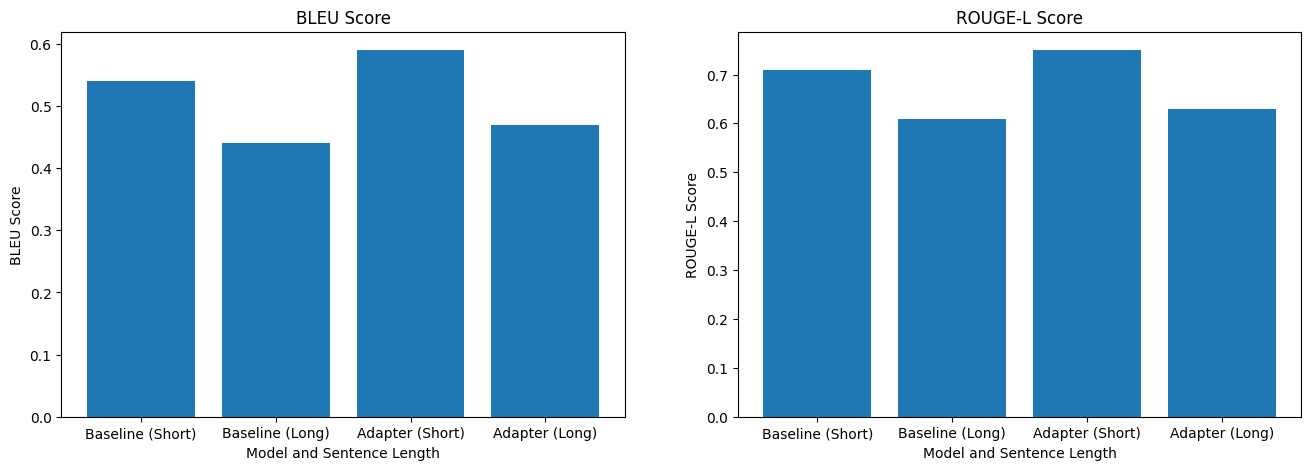

In [ ]:
# plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))

# bleu chart
ax1.bar(['Baseline (Short)', 'Baseline (Long)', 'Adapter (Short)', 'Adapter (Long)'],
        [baseline_short_bleu/100, baseline_long_bleu/100, adapter_short_bleu/100, adapter_long_bleu/100])
ax1.set_title('BLEU Score')
ax1.set_xlabel('Model and Sentence Length')
ax1.set_ylabel('BLEU Score')

# rouge chart
ax2.bar(['Baseline (Short)', 'Baseline (Long)', 'Adapter (Short)', 'Adapter (Long)'],
        [baseline_short_rouge['rougeL'].fmeasure, baseline_long_rouge['rougeL'].fmeasure,
         adapter_short_rouge['rougeL'].fmeasure, adapter_long_rouge['rougeL'].fmeasure])
ax2.set_title('ROUGE-L Score')
ax2.set_xlabel('Model and Sentence Length')
ax2.set_ylabel('ROUGE-L Score')

plt.show()

### MarianMTModel - Dakshitha Mandhalapu

This model, "Helsinki-NLP/opus-mt-en-fr" refers to a pre-trained machine translation model developed by the Helsinki NLP group. This model has been trained on large-scale datasets for translating text from English to French and vice versa. The model architecture and training process aim to capture the semantic and syntactic characteristics of both languages to produce accurate translations.





In [ ]:
french_dataset = load_dataset("demelin/wino_x", 'lm_en_fr')

In [ ]:
test_data = french_dataset['test']

english_translations = [sample['context_en'] for sample in test_data]
french_translations = [sample['context_fr'] for sample in test_data]

# Create DataFrame
fr_df = pd.DataFrame({'English': english_translations, 'French': french_translations})

fr_df = fr_df[fr_df.index % 2 == 0]
fr_df = fr_df[:298]
display(fr_df)

,English,French
0,The woman looked for a different vase for the ...,La femme a cherché un vase différent pour le b...
2,The song took longer to sing than the ballad b...,La chanson a pris plus de temps à chanter que ...
4,Sergey appreciated intricate designs and decid...,Sergey a apprécié les dessins complexes et a d...
6,Joe got into the school but not into the Unive...,Joe est entré à l' école mais pas à l' univers...
8,Online security was important to the school bu...,La sécurité en ligne était importante pour l' ...
...,...,...
586,The gangster tried to put the body into the ca...,Le gangster a essayé de mettre le corps dans l...
588,"His razor could not trim the beard very well, ...",Son rasoir ne pouvait pas très bien tailler la...
590,"In my opinion, oak is a far superior wood than...","À mon avis, le chêne est un bois de loin supér..."
592,Piper made a big batch of root beer and wanted...,Piper a fait un gros lot de root beer et voula...


In [ ]:
from transformers import MarianMTModel, MarianTokenizer

# Load pre-trained translation model and tokenizer
model_name = "Helsinki-NLP/opus-mt-en-fr"
model = MarianMTModel.from_pretrained(model_name)
tokenizer = MarianTokenizer.from_pretrained(model_name)

# Function to perform translation
def translate_text(text):
    # Tokenize input text
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)

    # Perform translation
    outputs = model.generate(**inputs)

    # Decode translated text
    translated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)

    return translated_text

# Translate each English sentence to French
translated_sentences = []
for english_sentence in fr_df['English']:
    translated_sentence = translate_text(english_sentence)
    translated_sentences.append(translated_sentence)

# Add translated sentences to DataFrame
fr_df['French_Translation'] = translated_sentences

# Display DataFrame with English and French translations
display(fr_df[['English', 'French_Translation']])


C:\Users\india\anaconda3\1\Lib\site-packages\transformers\models\marian\tokenization_marian.py:175: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")


,English,French_Translation
0,The woman looked for a different vase for the ...,La femme cherchait un vase différent pour le b...
2,The song took longer to sing than the ballad b...,La chanson a pris plus de temps à chanter que ...
4,Sergey appreciated intricate designs and decid...,Sergey a apprécié les dessins complexes et a d...
6,Joe got into the school but not into the Unive...,Joe est entré dans l'école mais pas à l'univer...
8,Online security was important to the school bu...,La sécurité en ligne était importante pour l'é...
...,...,...
586,The gangster tried to put the body into the ca...,Le gangster a essayé de mettre le corps dans l...
588,"His razor could not trim the beard very well, ...",Son rasoir ne pouvait pas très bien tailler la...
590,"In my opinion, oak is a far superior wood than...","À mon avis, le chêne est un bois bien supérieu..."
592,Piper made a big batch of root beer and wanted...,Piper a fait un gros lot de bière racine et vo...


In [ ]:
from sacrebleu import sentence_bleu

# Calculate BLEU score for each pair of original and translated sentences
bleu_scores = []
for ref, hyp in zip(fr_df['French'], fr_df['French_Translation']):
    bleu_score = sentence_bleu(hyp, [ref]).score
    bleu_scores.append(bleu_score)

# Add BLEU scores to DataFrame
fr_df['BLEU_Score'] = bleu_scores

# Display DataFrame with English, French translations, and BLEU scores
display(fr_df[['English', 'French_Translation', 'BLEU_Score']])


,English,French_Translation,BLEU_Score
0,The woman looked for a different vase for the ...,La femme cherchait un vase différent pour le b...,56.810968
2,The song took longer to sing than the ballad b...,La chanson a pris plus de temps à chanter que ...,100.000000
4,Sergey appreciated intricate designs and decid...,Sergey a apprécié les dessins complexes et a d...,80.405147
6,Joe got into the school but not into the Unive...,Joe est entré dans l'école mais pas à l'univer...,11.568681
8,Online security was important to the school bu...,La sécurité en ligne était importante pour l'é...,38.501732
...,...,...,...
586,The gangster tried to put the body into the ca...,Le gangster a essayé de mettre le corps dans l...,100.000000
588,"His razor could not trim the beard very well, ...",Son rasoir ne pouvait pas très bien tailler la...,57.025243
590,"In my opinion, oak is a far superior wood than...","À mon avis, le chêne est un bois bien supérieu...",46.836247
592,Piper made a big batch of root beer and wanted...,Piper a fait un gros lot de bière racine et vo...,58.770382


In [ ]:
from sacrebleu import corpus_bleu

# Reference translations (original French sentences)
references = fr_df['French'].tolist()

# Candidate translations (translated French sentences)
candidates = fr_df['French_Translation'].tolist()

# Calculate overall BLEU score
overall_bleu_score = corpus_bleu(candidates, [references]).score

print("Overall BLEU Score:", overall_bleu_score)


Overall BLEU Score: 57.56328470137776


In [ ]:
from rouge import Rouge

# Initialize Rouge
rouge = Rouge()

# Compute Rouge score
scores = rouge.get_scores(candidates, references, avg=True)
print("Rouge Scores:", scores)


Rouge Scores: {'rouge-1': {'r': 0.7621791208894542, 'p': 0.7823455236708481, 'f': 0.7708756931333741}, 'rouge-2': {'r': 0.6175523354159022, 'p': 0.6332935524534773, 'f': 0.6242364978567618}, 'rouge-l': {'r': 0.7576253258481986, 'p': 0.7777823529947897, 'f': 0.7663298195978675}}


In [ ]:
from bert_score import score

# Compute BERTScore
bert_scores = score(candidates, references, lang='fr')

# Extract precision, recall, and F1 scores from the results
precision_scores = bert_scores[0].tolist()
recall_scores = bert_scores[1].tolist()
f1_scores = bert_scores[2].tolist()

# Calculate the mean scores
mean_precision = sum(precision_scores) / len(precision_scores)
mean_recall = sum(recall_scores) / len(recall_scores)
mean_f1 = sum(f1_scores) / len(f1_scores)

# Print the mean scores
print("Mean BERTScore Precision:", mean_precision)
print("Mean BERTScore Recall:", mean_recall)
print("Mean BERTScore F1:", mean_f1)


Mean BERTScore Precision: 0.9518875775721249
Mean BERTScore Recall: 0.9540370934761611
Mean BERTScore F1: 0.9529045868239947


Dakshitha Mandhalapu: The bar chart below illustrates the evaluation metrics like BLEU, ROUGE, and BERTScore against their respective scores, providing a clear visualization of the model's effectiveness in translating text from English to French or vice versa.We can observe that the MarianMTModel acheived a very good bertscore of 0.95 indicating better overall translation performance.

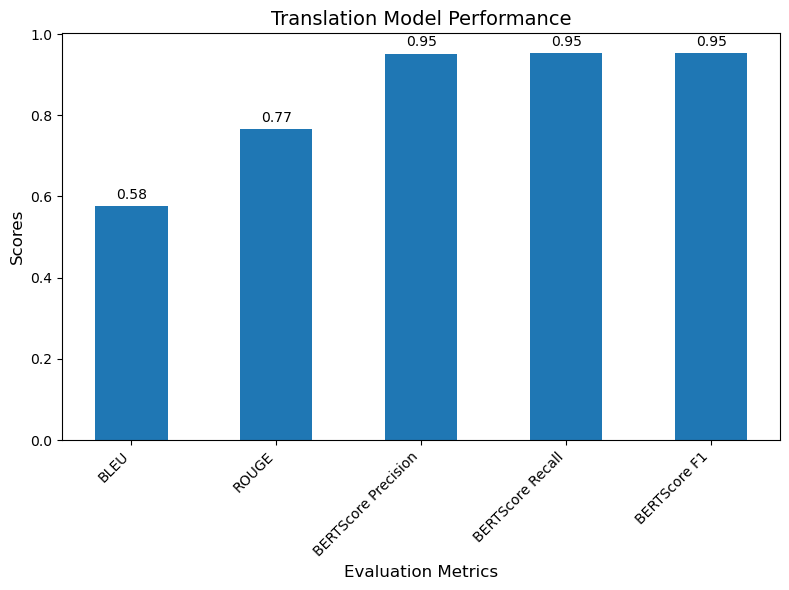

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Evaluation metrics and scores
metrics = ['BLEU', 'ROUGE', 'BERTScore Precision', 'BERTScore Recall', 'BERTScore F1']
values = [overall_bleu_score/ 100, scores['rouge-l']['f'], mean_precision, mean_recall, mean_f1]

# Set up the figure and axis
fig, ax = plt.subplots(figsize=(8, 6))

# Create a bar chart
bar_width = 0.5
x = np.arange(len(metrics))
rects = ax.bar(x, values, bar_width, label='values')

# Add labels and title
ax.set_xlabel('Evaluation Metrics', fontsize=12)
ax.set_ylabel('Scores', fontsize=12)
ax.set_title('Translation Model Performance', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(metrics, rotation=45, ha='right')

# Add value labels on top of bars
for rect in rects:
    height = rect.get_height()
    ax.annotate(f'{height:.2f}',
                xy=(rect.get_x() + rect.get_width() / 2, height),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center', va='bottom')

# Adjust layout and display the chart
plt.tight_layout()
plt.show()


Dakshitha Mandhalapu: The scatter plot below depicts the relationship between the length of English sentences and their corresponding BLEU scores, assuming data is sourced from a DataFrame containing English sentences, French translations, and BLEU scores. Each point on the scatter plot represents a sentence's length against its BLEU score, while the red regression line offers insight into the overall trend. The visualization aids in discerning any potential correlation between sentence length and BLEU scores, crucial for evaluating translation model performance.The plot shows that the points are scattered widely, it indicates variability in performance based on sentence length.

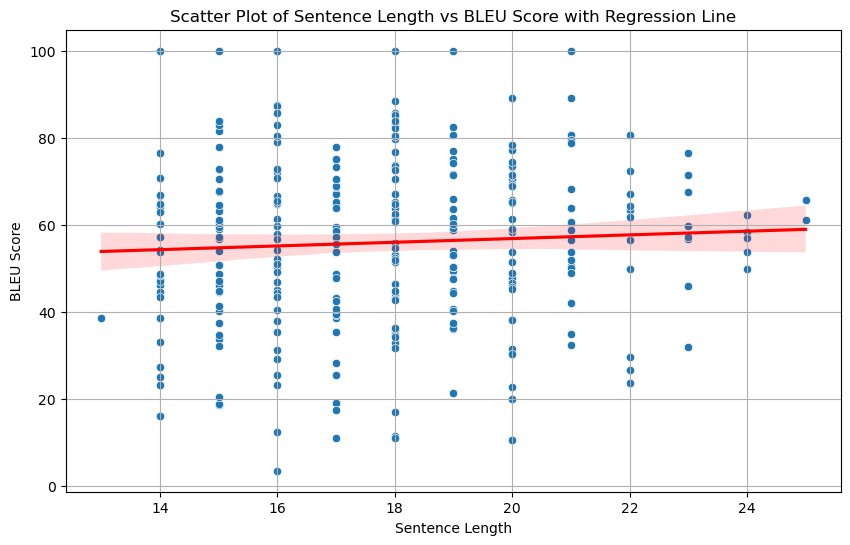

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Assuming fr_df contains the DataFrame with English sentences, French translations, and BLEU scores

# Create a DataFrame with English sentence lengths and BLEU scores
sentence_lengths = fr_df['English'].apply(lambda x: len(x.split()))
bleu_scores = fr_df['BLEU_Score']
data = pd.DataFrame({'Sentence Length': sentence_lengths, 'BLEU Score': bleu_scores})

# Plot scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=data, x='Sentence Length', y='BLEU Score')

# Fit regression line
sns.regplot(data=data, x='Sentence Length', y='BLEU Score', scatter=False, color='red')

plt.title('Scatter Plot of Sentence Length vs BLEU Score with Regression Line')
plt.xlabel('Sentence Length')
plt.ylabel('BLEU Score')
plt.grid(True)
plt.show()
